## Initialize VGG-16 model

In [2]:
import torch
import torchvision.models as models

# Load pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze model parameters
for param in vgg16.parameters():
    param.requires_grad = False

# Print the model architecture
print(vgg16)

/Users/rossaroni/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rossaroni/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Intialize forward hooks to get each layer activation

In [3]:
import torch.nn as nn
activation = {}

def hook_fn(module, input, output):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
#         print(f"{module.__class__.__name__} output shape:", output.shape)
        activation[module] = output.detach()

conv_layers = [vgg16.features[0], vgg16.features[2], vgg16.features[5], vgg16.features[7], 
               vgg16.features[10], vgg16.features[12], vgg16.features[14], vgg16.features[17], 
               vgg16.features[19], vgg16.features[21], vgg16.features[24], vgg16.features[26], 
               vgg16.features[28]]
fc_layers = [vgg16.classifier[0], vgg16.classifier[3]]

# Register hooks for each Conv and FC layer
for layer in conv_layers + fc_layers:
    layer.register_forward_hook(hook_fn)

## Test on a sample image

In [4]:
import torchvision.transforms as transforms
from PIL import Image

# Load the image
image = Image.open("./lamem/images/00000002.jpg")

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Move input batch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Set the model to evaluation mode
vgg16.eval()

# Perform inference
with torch.no_grad():
    output = vgg16(input_batch)

# Convert output probabilities to predicted class
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class = torch.argmax(probabilities)

# Load the ImageNet class labels
with open("./imagenet_class_labels.txt") as f:  # Replace "imagenet_classes.txt" with the file containing class labels
    class_labels = [line.strip()[4:] for line in f.readlines()]

# Get the predicted class label
predicted_label = class_labels[predicted_class]

print("Predicted class label:", predicted_label)
print("Predicted probability:", probabilities[predicted_class].item())


Predicted class label:  'gondola',
Predicted probability: 0.9050655364990234


In [5]:
list(activation.keys())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Linear(in_features=25088, out_features=4096, bias=True),
 Linear(in_features=4096, out_features

In [6]:
import numpy as np
(activation[list(activation.keys())[0]]).sum(),(activation[list(activation.keys())[1]]).sum()

(tensor(1159888.8750), tensor(2089358.1250))

In [7]:
list(activation.keys())[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## Run experiment on memorability test set 1

In [8]:
image_mem_scores = {}
with open('./lamem/splits/test_1.txt') as f:
    for line in f:
        image_id, mem_score = line.strip().split(' ')
        image_mem_scores[image_id] = float(mem_score)

# Load the ImageNet class labels
with open("./imagenet_class_labels.txt") as f:  # Replace "imagenet_classes.txt" with the file containing class labels
    class_labels = [line.strip()[4:] for line in f.readlines()]

In [9]:
vgg16.eval()
predictions = {}
layer_ids = ['1.1','1.2','2.1','2.2','3.1','3.2','3.3','4.1','4.2','4.3','5.1','5.2','5.3','6','7']

image_layer_responses = {}
for i,image_id in enumerate(image_mem_scores):
    if i % 100 == 0:
        print(100*i/len(image_mem_scores),'%')
    activation = {}
    layer_response = {}
    image = Image.open(f"./lamem/images/{image_id}")

    # Preprocess
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),  # Ensure the image has three channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        output = vgg16(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class = torch.argmax(probabilities)

    predicted_label = class_labels[predicted_class]
    predictions[image_id] = [predicted_label,probabilities[predicted_class].item()]
    
    for j,key in enumerate(activation.keys()):
        layer_response[layer_ids[j]] = activation[key].sum().item()
    image_layer_responses[image_id] = layer_response
#     print(layer_response,image_mem_scores[image_id])
#     break

0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %


## Reshape data

In [10]:
layer_distributions = {}
for layer_id in layer_ids:
    layer_distributions[layer_id] = {'activations':[],'mem_scores':[]}
    
for image_id, layer_response_dict in image_layer_responses.items():
    for layer_id, layer_response in layer_response_dict.items():
        layer_distributions[layer_id]['activations'].append(layer_response)
        layer_distributions[layer_id]['mem_scores'].append(image_mem_scores[image_id])

## Calculate Pearson correlation

In [11]:
from scipy.stats import pearsonr

coeffs = []
for layer_id, activations_and_mem_scores in layer_distributions.items():
    x,y = activations_and_mem_scores['activations'],activations_and_mem_scores['mem_scores']
    corr_coefficient, p_value = pearsonr(x,y)
    print(layer_id)
    print("Pearson correlation coefficient:", corr_coefficient)
    print("p-value:", p_value,'\n')
    coeffs.append(corr_coefficient)


1.1
Pearson correlation coefficient: 0.011820158871191479
p-value: 0.23724164715606685 

1.2
Pearson correlation coefficient: -0.030264283727175996
p-value: 0.002472037851843738 

2.1
Pearson correlation coefficient: -0.0012823123797970218
p-value: 0.8979786233281828 

2.2
Pearson correlation coefficient: 0.009656363709137908
p-value: 0.33427532815940014 

3.1
Pearson correlation coefficient: 0.049160422323314315
p-value: 8.725382755054714e-07 

3.2
Pearson correlation coefficient: 0.07872893316996382
p-value: 3.166878026447236e-15 

3.3
Pearson correlation coefficient: 0.09865652776123601
p-value: 4.6673929662921066e-23 

4.1
Pearson correlation coefficient: 0.13482678619483476
p-value: 8.731023930074697e-42 

4.2
Pearson correlation coefficient: 0.14314171589713198
p-value: 6.2879911330147105e-47 

4.3
Pearson correlation coefficient: 0.14334388296653378
p-value: 4.672277602138563e-47 

5.1
Pearson correlation coefficient: 0.14503319329076736
p-value: 3.8405417656385845e-48 

5.2
Pea

Text(0, 0.5, 'Pearson correlation')

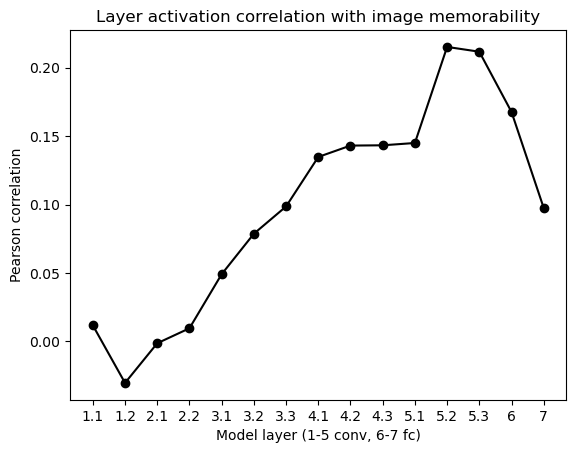

In [12]:
import matplotlib.pyplot as plt

plt.plot(layer_ids,coeffs,marker='o',color='k')
plt.title('VGG-16 layer activation correlation with image memorability')
plt.xlabel('Model layer (1-5 conv, 6-7 fc)')
plt.ylabel('Pearson correlation')

In [13]:
max(coeffs)

0.21522208132825787

In [14]:
coeffs

[0.011820158871191479,
 -0.030264283727175996,
 -0.0012823123797970218,
 0.009656363709137908,
 0.049160422323314315,
 0.07872893316996382,
 0.09865652776123601,
 0.13482678619483476,
 0.14314171589713198,
 0.14334388296653378,
 0.14503319329076736,
 0.21522208132825787,
 0.21171975115122543,
 0.16769945603561343,
 0.09751883356395954]